In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import math

import utils
from model import UNet
from config import Config

In [2]:
trans = transforms.ToTensor()
reverse_trans = transforms.ToPILImage()
train_set = datasets.MNIST("data", train=True, download=True, transform=trans)
test_set = datasets.MNIST("data", train=False, download=True, transform=trans)

In [3]:
train_loader = DataLoader(train_set, batch_size=Config.batch_size, 
    shuffle=True, num_workers=4)

test_loader = DataLoader(test_set, batch_size=Config.batch_size, 
    shuffle=True, num_workers=4)

print(len(train_set))

60000


torch.Size([2, 1, 28, 28])
(28, 28)


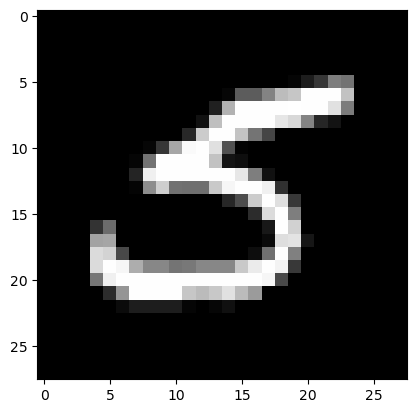

In [4]:
for (X, y) in train_loader:
    print(X.size())
    X = X[0]

    Config.channels = X.size()[0]
    Config.img_size = X.size()[1]

    img = reverse_trans(X)
    print(img.size)
    plt.imshow(img, cmap ='gray')
    break

In [5]:
def beta_schedule(timesteps):
    return torch.linspace(Config.beta_start, Config.beta_end, timesteps)

In [6]:
betas = beta_schedule(Config.timesteps)
alphas = 1.0 - betas

alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

sqrt_recip_alphas = torch.sqrt(1 / alphas)

posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

In [7]:
def extract(vec, t, x_shape):
    batch_size = t.shape[0]
    out = vec.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [8]:
def get_noisy_image(x_start, step, noise=None):
    if noise == None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, step, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, step, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [9]:
for (X, y) in train_loader:
    X = X[0]
    imgs = [get_noisy_image(X, torch.tensor([t])) for t in [0, 50, 100, 150, 199]]
    imgs = list(map(lambda img : reverse_trans(img), imgs))
    print(imgs[0].size)
    utils.plot(imgs, cmap ='gray')
    break

(28, 28)


In [10]:
def get_denoised_image(x, step, model):
    betas_t = extract(betas, step, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, step, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, step, x.shape)

    model_mean = sqrt_recip_alphas_t * (x - betas_t  * model(x, step) / sqrt_one_minus_alphas_cumprod_t)

    if step[0] == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        posterior_variance_t = extract(posterior_variance, step, x.shape)
        return model_mean + noise * posterior_variance

In [11]:
def get_denoised_images(shape, timesteps, model):
    device = next(model.parameters()).device
    b_size = shape[0]

    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = get_denoised_image(img, torch.full((b_size,), i, device=device, dtype=torch.long), model)
        imgs.append(img.cpu().numpy())
    return imgs

In [12]:
def sample(model, img_size, batch_size=16, channels=3):
    return get_denoised_images((batch_size, channels, img_size, img_size), Config.timesteps, model)

In [13]:
def diff_loss(x_start, step, model, loss_type='huber'):
    noise = torch.randn_like(x_start)

    noisy_img = get_noisy_image(x_start, step, noise=noise)
    # print(noisy_img.shape)
    predicted_noise = model(noisy_img, step)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == 'huber':
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [14]:
model = UNet(Config.channels, Config.channels, Config.time_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=Config.lr)
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

UNet(
  (time_embedding): TimeEmbedding(
    (time_embedding): Sequential(
      (0): Linear(in_features=28, out_features=112, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=112, out_features=112, bias=True)
    )
  )
  (in_conv): InConv(
    (in_conv): ResidualDoubleConvBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (conv2): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (mlp): Sequential(
        (0): SiLU()
        (1): Linear(in_features=112, out_features=64, bias=True)
      )
      (res

In [15]:
index = 0
torch.autograd.set_detect_anomaly(True)
for epoch in range(Config.epochs):
    for (X, y) in train_loader:
        optimizer.zero_grad()
        X = X.to(device)

        step = torch.randint(0, Config.timesteps, (Config.batch_size,), device=device)
        loss = diff_loss(X, step, model)

        loss.backward()
        optimizer.step()

        index += 1
        if (index % 10 == 0):
            print(f"Loss: {loss.item() / 100}%")

Loss: 0.03204716369509697


KeyboardInterrupt: 

In [ ]:
# imgs = sample(model, img_size=28, channels=1, batch_size=2)
# imgs = list(map(lambda img : reverse_trans(imgs), imgs))
# print(imgs[0].size)
# utils.plot(imgs, cmap ='gray')